# **NLP Project**

In [1]:
import os
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline, BitsAndBytesConfig
import sys
sys.path.append("src")
from data_loading import *
from prompt_utils import *

torch.cuda.is_available()

True

### Dataset downloading

In [2]:
DATASET_PATH = "dataset"

if not os.path.isdir(DATASET_PATH):
    !wget -nc -P . https://allenai.org/data/proofwriter
    !unzip -q -d . proofwriter
    !mv proofwriter-dataset-V2020.12.3 $DATASET_PATH
    !rm proofwriter

### Dataset loading

In [3]:
dataset = ProofWriterDataset(None, DATASET_PATH + "/OWA/depth-3/meta-train.jsonl")
examples_dataset = ProofWriterDataset(None, DATASET_PATH + "/OWA/depth-3/meta-dev.jsonl")

In [4]:
examples = [examples_dataset[12]] #[(i, e) for i, e in enumerate(examples_dataset) if i < 20]
examples

[{'context': 'triple1: The bear is kind. triple2: The bear is young. triple3: The mouse is red. rule1: If the mouse likes the bear then the bear likes the mouse. rule2: If something likes the bear then the bear visits the mouse. rule3: If something is young then it likes the bear. rule4: If something is red then it sees the bear. rule5: If something visits the mouse then the mouse visits the bear. rule6: If something is kind and it visits the bear then the bear is young. ',
  'question': 'The bear visits the mouse.',
  'label': 'True',
  'proof': '((((triple2) -> (rule3 % int2))) -> (rule2 % int1)) ; with int1 = The bear visits the mouse.int2 = The bear likes the bear.'}]

### Model loading

In [ ]:
torch.random.manual_seed(0)

model_name = "mistralai/Mistral-7B-Instruct-v0.3" # "HuggingFaceTB/SmolLM3-3B" # "mistralai/Mistral-7B-Instruct-v0.1" # "microsoft/Phi-4-mini-instruct"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype="float16",  # oppure "bfloat16" se supportato
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4"
)

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    # quantization_config=bnb_config,
    device_map="auto",
    torch_dtype=torch.float16,
    # torch_dtype="auto",
    trust_remote_code=True,
    attn_implementation="eager"
)

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = "eos_token_id"
 
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    batch_size=1,
    device_map="auto"
)


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Device set to use cuda:0


### Execution

In [6]:
def bool_to_bin(b):
    assert b in ["True", "False"], b
    return int(b == "True")

y_true = []
y_pred = []

prompts = []

for i, e in enumerate(dataset):
    if i > 1: break

    y_true.append(bool_to_bin(e["label"]))
    # print(e["question"])
    # print(e["proof"])
    prompts.append(build_one_shot_prompt(e, examples, proof=True))


{'preamble': 'You will be shown some examples of questions and answers based on a logic theory. Your task is to evaluate a question based on a new theory.\nRespond with only one word: either True or False. Include the proof of your answer, formatted as the example.\n', 'example_introduction_1': 'Example 1:', 'example_theory_1': 'Theory:\ntriple1: The bear is kind. triple2: The bear is young. triple3: The mouse is red. rule1: If the mouse likes the bear then the bear likes the mouse. rule2: If something likes the bear then the bear visits the mouse. rule3: If something is young then it likes the bear. rule4: If something is red then it sees the bear. rule5: If something visits the mouse then the mouse visits the bear. rule6: If something is kind and it visits the bear then the bear is young. ', 'example_question_1': 'Question:\nThe bear visits the mouse.', 'example_answer_1': 'Answer:', 'example_label_1': 'True', 'example_proof_1': '((((triple2) -> (rule3 % int2))) -> (rule2 % int1)) ; 

In [7]:
encoded = tokenizer([p[0] for p in prompts], return_offsets_mapping=True, return_tensors="pt", padding=True).to("cuda")
offset_mapping = encoded.pop("offset_mapping")

In [8]:
generation_args = {
    "output_attentions" : True,
    "return_dict_in_generate": True,
    "max_new_tokens": 10,
    "do_sample": False
}

with torch.no_grad():
    outputs = model.generate(**encoded, **generation_args)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


You will be shown some examples of questions and answers based on a logic theory. Your task is to evaluate a question based on a new theory.
Respond with only one word: either True or False. Include the proof of your answer, formatted as the example.

Example 1:
Theory:
triple1: The bear is kind. triple2: The bear is young. triple3: The mouse is red. rule1: If the mouse likes the bear then the bear likes the mouse. rule2: If something likes the bear then the bear visits the mouse. rule3: If something is young then it likes the bear. rule4: If something is red then it sees the bear. rule5: If something visits the mouse then the mouse visits the bear. rule6: If something is kind and it visits the bear then the bear is young. 
Question:
The bear visits the mouse.
Answer:
True
((((triple2) -> (rule3 % int2))) -> (rule2 % int1)) ; with int1 = The bear visits the mouse.int2 = The bear likes the bear.

Now, evaluate the following.
Theory:
triple1: The cat chases the cow. triple2: The cat is b

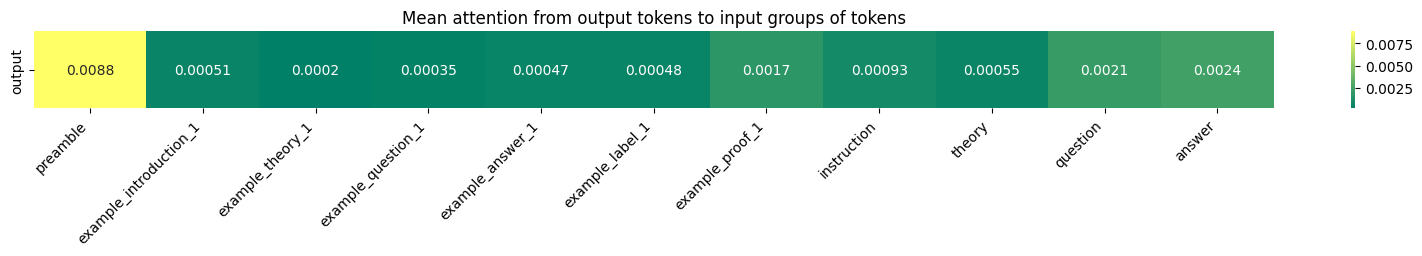

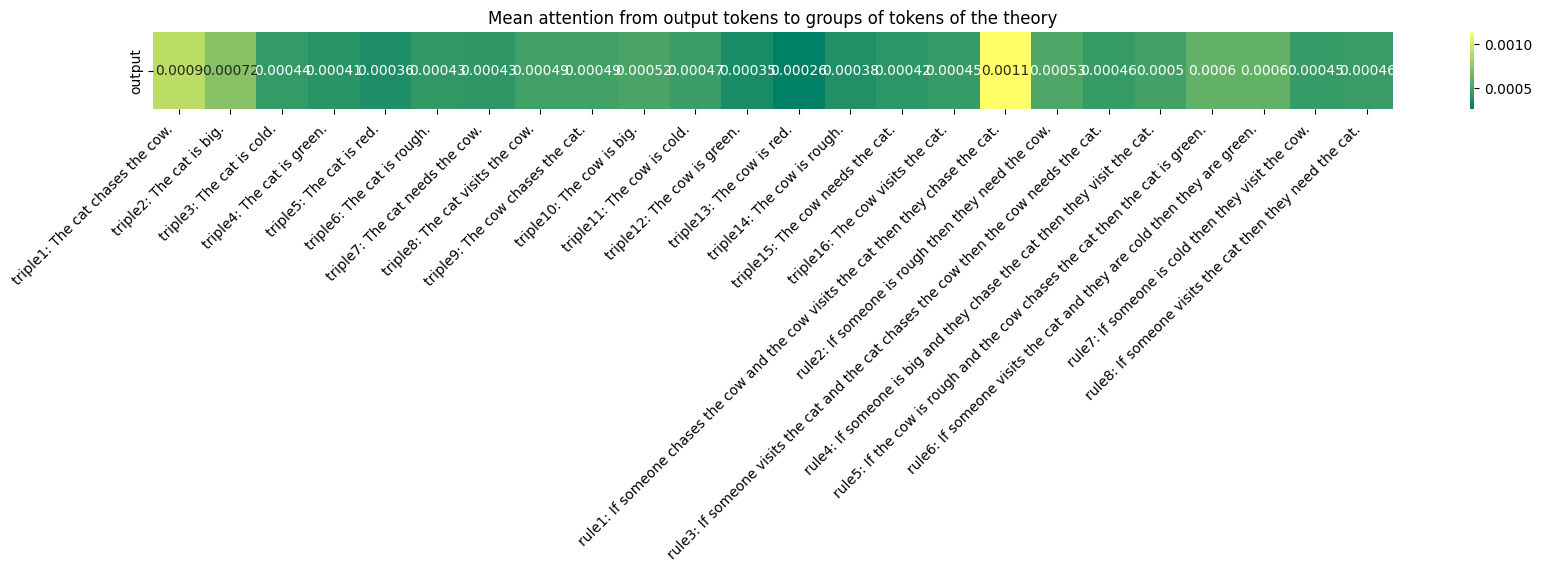

You will be shown some examples of questions and answers based on a logic theory. Your task is to evaluate a question based on a new theory.
Respond with only one word: either True or False. Include the proof of your answer, formatted as the example.

Example 1:
Theory:
triple1: The bear is kind. triple2: The bear is young. triple3: The mouse is red. rule1: If the mouse likes the bear then the bear likes the mouse. rule2: If something likes the bear then the bear visits the mouse. rule3: If something is young then it likes the bear. rule4: If something is red then it sees the bear. rule5: If something visits the mouse then the mouse visits the bear. rule6: If something is kind and it visits the bear then the bear is young. 
Question:
The bear visits the mouse.
Answer:
True
((((triple2) -> (rule3 % int2))) -> (rule2 % int1)) ; with int1 = The bear visits the mouse.int2 = The bear likes the bear.

Now, evaluate the following.
Theory:
triple1: The cat chases the cow. triple2: The cat is b

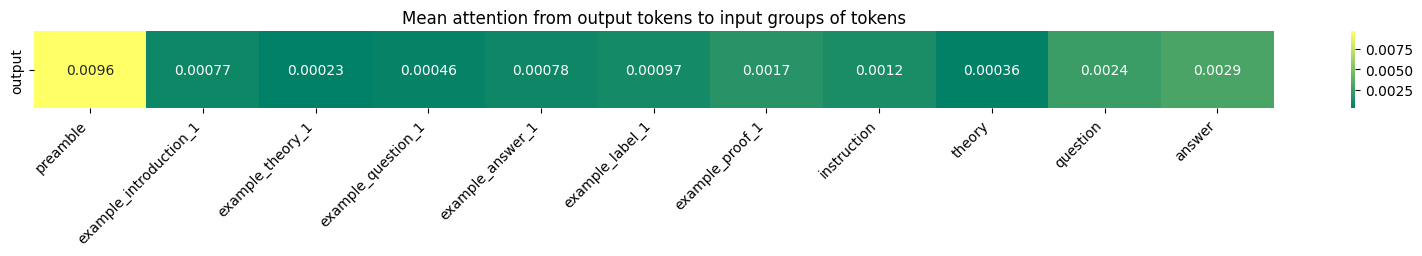

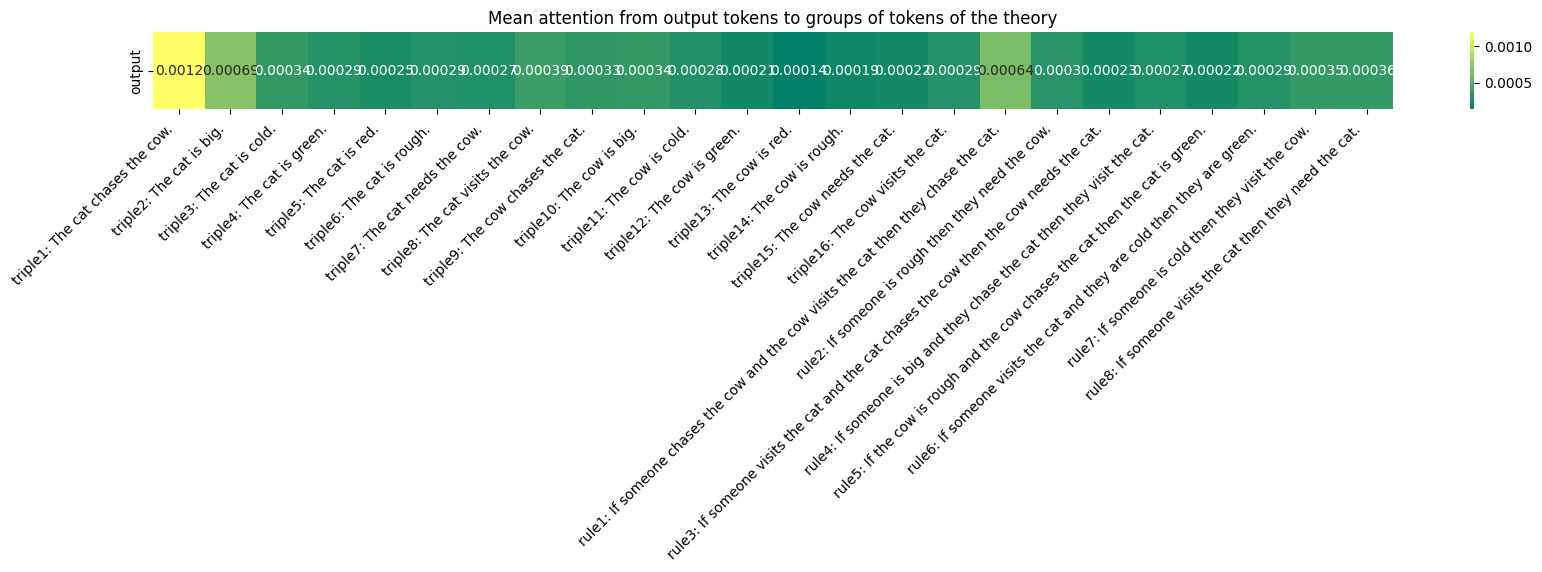

In [9]:
for i, (prompt, prompt_segmentation, theory_segmentation) in enumerate(prompts):
    
    print(prompt)
    print("----")
    print(tokenizer.decode(outputs.sequences[0], skip_special_tokens=True)[len(prompt):])

    input_ids = encoded["input_ids"][i]
    offsets = offset_mapping[i]
    groups_delimiters_by_characters = reduce(lambda acc, x : acc + [x[1]], prompt_segmentation.values(), [0])
    groups_intervals_by_token = get_groups_delimiter_intervals_by_tokens(groups_delimiters_by_characters, offsets)
    n_input_tokens = groups_intervals_by_token[-1][-1]

    # print([layer[i].detach().to(torch.float32).cpu().numpy() for layer in outputs.attentions])

    prompt_length = encoded["input_ids"].shape[-1]
    new_token_ids = outputs.sequences[0][prompt_length:]
    tokens = tokenizer.convert_ids_to_tokens(new_token_ids)
    non_special_tokens = [t for t in tokens if not tokenizer.special_tokens_map.get(t) and t not in tokenizer.all_special_tokens]
    # print(f"Non special tokens generated: {len(non_special_tokens)}")

    means = np.zeros(n_input_tokens)
    means2 = []
    
    for k, attn_gen_token in enumerate(outputs.attentions):
        if k == 0: continue # attention map only referred to input tokens
        if k == len(non_special_tokens)+1: break

        for l, layer in enumerate(attn_gen_token):
            for head in layer[i].detach().to(torch.float32).cpu().numpy():
                means += head[0][:n_input_tokens]
            means[l] /= k

        means2.append(np.mean([np.mean([head[0][:n_input_tokens] for head in layer[i].detach().to(torch.float32).cpu().numpy()], axis=0) for layer in attn_gen_token], axis=0))
    

    #attentions = [token for token in outputs.attentions] # extracting prompt attention
    #layers = [l[i].detach().to(torch.float32).cpu().numpy() for l in attentions]

    mean_output_attention = np.mean(means2, axis=0)

    # mean_output_attention = np.mean([np.mean([head[n_input_tokens:][:n_input_tokens].sum(axis=0) for head in layer], axis=0) for layer in layers], axis=0)

    groups_mean_attention = np.zeros((1, len(prompt_segmentation)))

    for j, (start, end) in enumerate(groups_intervals_by_token):
        values = mean_output_attention[start:end]
        groups_mean_attention[0][j] = np.mean(values)

    # 
    theory_intervals_by_token = get_groups_delimiter_intervals_by_tokens(theory_segmentation, offsets)
    mean_attention_on_theory_components = np.zeros((1, len(theory_intervals_by_token)))

    
    for j, (start, end) in enumerate(theory_intervals_by_token):
        values = mean_output_attention[start:end]
        mean_attention_on_theory_components[0][j] = np.mean(values)

    
    plt.figure(figsize=(20, 1))
    hm = sns.heatmap(groups_mean_attention, xticklabels=list(prompt_segmentation.keys()), yticklabels=["output"], cmap="summer", annot=True)
    hm.set_xticklabels(hm.get_xticklabels(), rotation=45, ha="right")
    plt.title("Mean attention from output tokens to input groups of tokens")
    plt.xticks(rotation=45)
    plt.show()

    plt.figure(figsize=(20, 1))
    hm = sns.heatmap(mean_attention_on_theory_components, xticklabels=list([prompt[theory_segmentation[i] : theory_segmentation[i+1]] for i in range(len(theory_segmentation)-1)]), yticklabels=["output"], cmap="summer", annot=True)
    hm.set_xticklabels(hm.get_xticklabels(), rotation=45, ha="right")
    plt.title("Mean attention from output tokens to groups of tokens of the theory")
    plt.show()

    if i == 3: break
    

In [10]:
prompt_length = encoded["input_ids"].shape[-1]
new_token_ids = outputs.sequences[0][prompt_length:]
tokens = tokenizer.convert_ids_to_tokens(new_token_ids)

non_special_tokens = [t for t in tokens if not tokenizer.special_tokens_map.get(t) and t not in tokenizer.all_special_tokens]

print(f"Token non speciali generati: {len(non_special_tokens)}")
non_special_tokens

Token non speciali generati: 10


['False', '<0x0A>', 'tri', 'ple', '1', '2', '<0x0A>', '<0x0A>', 'The', 'ory']

In [ ]:
max(means2[0])

np.float32(0.29892585)

In [ ]:
max(means2[2])

np.float32(0.30871958)

In [ ]:
n_input_tokens

663

In [ ]:
encoded["input_ids"].shape

torch.Size([5, 667])

In [ ]:
outputs.sequences[0]

tensor([    1,   995,   622,   347,  4894,   264,  5742,   304,   264,  2996,
        28723,  3604,  3638,   349,   298, 15627,   272,  2996,  2818,   356,
          272,  5742, 28723,    13,  1146, 19571,   395,   865,   624,  1707,
        28747,  2477,  6110,   442,  8250, 28723, 26438,   272,  7167,   302,
          574,  4372, 28725,  1221, 11985,   390,   272,  2757, 28723,    13,
        20275, 28747,    13,  1014,   695, 28747,    13, 13862,   792, 28740,
        28747,   415,  5255,   484,  2018,   272, 12072, 28723, 22212, 28750,
        28747,   415,  5255,   349,  2032, 28723, 22212, 28770, 28747,   415,
         5255,   349,  5256, 28723, 22212, 28781, 28747,   415,  5255,   349,
         5344, 28723, 22212, 28782, 28747,   415,  5255,   349,  2760, 28723,
        22212, 28784, 28747,   415,  5255,   349,  8654, 28723, 22212, 28787,
        28747,   415,  5255,  3208,   272, 12072, 28723, 22212, 28783, 28747,
          415,  5255, 17217,   272, 12072, 28723, 22212, 28774, 

In [ ]:
outputs.attentions[1][0].shape
# 88 32 5 32 667 667

torch.Size([5, 32, 1, 668])

In [ ]:
len(attentions)

50

In [ ]:
for i, layer in enumerate(attentions):
    print(f"i = {i}: shape = {layer.shape}")

i = 0: shape = (5, 32, 667, 667)
i = 1: shape = (5, 32, 1, 668)
i = 2: shape = (5, 32, 1, 669)
i = 3: shape = (5, 32, 1, 670)
i = 4: shape = (5, 32, 1, 671)
i = 5: shape = (5, 32, 1, 672)
i = 6: shape = (5, 32, 1, 673)
i = 7: shape = (5, 32, 1, 674)
i = 8: shape = (5, 32, 1, 675)
i = 9: shape = (5, 32, 1, 676)
i = 10: shape = (5, 32, 1, 677)
i = 11: shape = (5, 32, 1, 678)
i = 12: shape = (5, 32, 1, 679)
i = 13: shape = (5, 32, 1, 680)
i = 14: shape = (5, 32, 1, 681)
i = 15: shape = (5, 32, 1, 682)
i = 16: shape = (5, 32, 1, 683)
i = 17: shape = (5, 32, 1, 684)
i = 18: shape = (5, 32, 1, 685)
i = 19: shape = (5, 32, 1, 686)
i = 20: shape = (5, 32, 1, 687)
i = 21: shape = (5, 32, 1, 688)
i = 22: shape = (5, 32, 1, 689)
i = 23: shape = (5, 32, 1, 690)
i = 24: shape = (5, 32, 1, 691)
i = 25: shape = (5, 32, 1, 692)
i = 26: shape = (5, 32, 1, 693)
i = 27: shape = (5, 32, 1, 694)
i = 28: shape = (5, 32, 1, 695)
i = 29: shape = (5, 32, 1, 696)
i = 30: shape = (5, 32, 1, 697)
i = 31: shape = 

In [ ]:
tokenizer.decode(outputs.sequences[0], skip_special_tokens=True)

'Include the proof of your answer, formatted as the example.\nExample:\nTheory:\ntriple1: The dog is kind. triple2: The mouse sees the tiger. triple3: The squirrel sees the tiger. triple4: The tiger is round. rule1: If someone chases the mouse and they eat the squirrel then the mouse sees the dog. rule2: If someone is blue and they see the tiger then the tiger sees the squirrel. rule3: If someone sees the tiger then they are blue. rule4: If someone sees the mouse then the mouse chases the tiger. rule5: If someone is kind and they eat the dog then they eat the mouse. rule6: If someone sees the squirrel then the squirrel chases the dog. rule7: If someone sees the squirrel and they eat the squirrel then the squirrel sees the tiger. rule8: If the squirrel eats the tiger then the squirrel chases the dog. \nQuestion:\nThe squirrel chases the dog.\nTrue\n((((((triple2) -> (rule3 % int3)) triple2) -> (rule2 % int2))) -> (rule6 % int1)) ; with int1 = The squirrel chases the dog.int2 = The tiger

In [ ]:
predicted_ids = torch.argmax(outputs.logits, dim=-1)
decoded = tokenizer.decode(predicted_ids[0], skip_special_tokens=True)
print(decoded)

Q
 need required a list of a question. Your task is to explain the theory based on the theory.

earch with " " word. " " or False.
 not explain anyuation or capital or or any other text.

: TrueTheory: AllAllanglets +  cat is brown.
2: The dog is the dogiger.
3: The tirrel is the birdiger.
4: The tiger sees not.
:: If triple seesases a mouse, the see the mouseirrel, the t is the t. rule2: If someone ch kind then they eat the mouseiger then the mouseiger is the mouseirrel.
3: If someone is the tiger and the see blue.
4: If someone is the dog then they mouse seesases the squiger.
5: If someone sees blue then they see the squ then the see the squ.
6: If someone is the mouseirrel then they mouseirrel seesases the mouse. rule7: If someone is the dogirrel then the eat the dogirrel then they mouseirrel sees the mouseiger. rule8: If someone mouseirrel seesats the tiger then the tirrel seesases the mouse. rule
Question: TheThe mouseirrel seesases the dog.
An orFalse((((((ple1: ( (tri1)) rule())

In [ ]:
prompt_segmentation["theory"][1]

2052

In [ ]:
prompt[prompt_segmentation["theory"][0]: prompt_segmentation["theory"][1]]

'wing.\nTheory:\ntriple1: The cat chases the cow. triple2: The cat is big. triple3: The cat is cold. triple4: The cat is green. triple5: The cat is red. triple6: The cat is rough. triple7: The cat needs the cow. triple8: The cat visits the cow. triple9: The cow chases the cat. triple10: The cow is big. triple11: The cow is cold. triple12: The cow is green. triple13: The cow is red. triple14: The cow is rough. triple15: The cow needs the cat. triple16: The cow visits the cat. rule1: If someone chases the cow and the cow visits the cat then they chase the cat. rule2: If someone is rough then they need the cow. rule3: If someone visits the cat and the cat chases the cow then the cow needs the cat. rule4: If someone is big and they chase the cat then they visit the cat. rule5: If the cow is rough and the cow chases the cat then the cat is green. rule6: If someone visits the cat and they are cold then they are green. rule7: If someone is cold then they visit the cow. rule8: If someone visit

In [ ]:
for i, res in enumerate(pipe(prompts, **generation_args)):
    # print(res)
    try:
        generated_text = res[0]["generated_text"]
        y_pred.append(bool_to_bin(generated_text.split()[0]))
    except:
        print(i)

ValueError: When passing chat dicts as input, each dict must have a 'role' and 'content' key.

In [ ]:
# TEST
prompt, prompt_segmentation = build_one_shot_prompt(e, example_elem)

encoding = tokenizer(prompt, return_offsets_mapping=True, return_tensors="pt")
tokens = tokenizer.convert_ids_to_tokens(encoding["input_ids"][0])
offsets = encoding["offset_mapping"][0]

outputs = model(**encoding.to("cuda"))

In [ ]:
attn = outputs.attentions[-1][0, 0].detach().to(torch.float32).cpu().numpy()

group_indices_on_characters = reduce(lambda acc, x : acc + [x[1]], prompt_segmentation.values(), [0])

i = 0
group_indices_on_tokens = []
for gi in group_indices_on_characters:
    while offsets[i][1] < gi: i += 1
    group_indices_on_tokens.append(i)

attention_to_group = attn[:, group_indices_on_tokens].sum()

In [ ]:
group_indices_on_characters

[0, 211, 219, 957, 995, 999, 1028, 1717, 1763]

In [ ]:
group_indices_on_tokens

[0, 48, 50, 260, 274, 276, 284, 477, 490]

In [ ]:
def to_couples(l):
    if len(l) == 2: return [(l[0], l[1])]
    return [(l[0], l[1])] + to_couples(l[1:])

groups_intervals = to_couples(group_indices_on_tokens)
groups_intervals

[(0, 48),
 (48, 50),
 (50, 260),
 (260, 274),
 (274, 276),
 (276, 284),
 (284, 477),
 (477, 490)]

In [ ]:
group_attention = np.zeros((1, len(prompt_segmentation)))

for i, (start, end) in enumerate(groups_intervals):
    values = attn[-1][start:end]
    group_attention[0][i] = values.mean()

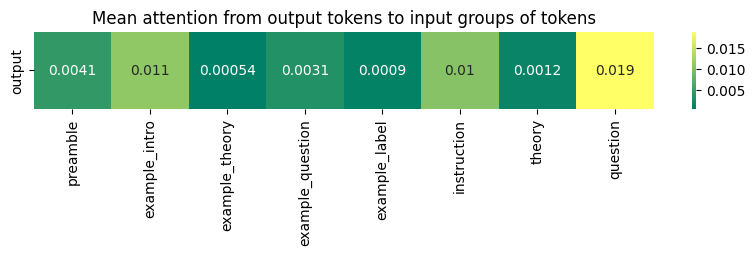

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 1))
sns.heatmap(group_attention, xticklabels=list(prompt_segmentation.keys()), yticklabels=["output"], cmap="summer", annot=True)
plt.title("Mean attention from output tokens to input groups of tokens")
plt.show()

In [ ]:
attn_all_layers = outputs.attentions

prompt_len = encoded["input_ids"].shape[1]

last_layer_attn = attn_all_layers[-1]  # [batch, num_heads, seq_len, seq_len]


attn_mean = last_layer_attn.mean(dim=1)  # [batch, seq_len, seq_len]


last_token_attn = attn_mean[0, -1]  # [seq_len]


prompt_attn = last_token_attn[:prompt_len]

tokens = tokenizer.convert_ids_to_tokens(encoded["input_ids"][0])
for tok, score in zip(tokens, prompt_attn.tolist()):
    print(f"{tok:15s} -> {score:.4f}")

AttributeError: 'tuple' object has no attribute 'mean'

In [ ]:
last_layer_attn[0].shape

torch.Size([5, 32, 1, 716])